# MUM 2023-24 Regularyzacja - gradienty, inicjalizacja, dropout, batchnorm

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Stabilność uczenia
* uczenie potrafi być bardzo niestabilne
  * podstawowe zasady inicjalizacji
    * wagi muszą być różne, np. w MLP identyczne wagi będą prowadzić do niewielkiej różnorodności neuronów
      * takie neurony wykrywają te same cechy
    * przy sigmoidalnej funkcji aktywacji
      * wagi o dużych wartościach bezwzględnych będą prowadzić do sysokich/niskich sum $\sum_jw_{ij}y_j$
      * to da gradient o niskiej wartości i powolne uczenie już na początku
### zanikające gradienty
* pisał Hochreiter w swojej pracy magisterskiej w 1991, jednak wyniki nie były szeroko znane, a praca była po niemiecku
* w głębokich sieciach aktywacja ukryta jest funkcją poprzedniej warstwy, a realizowana funkcja jest złożeniem $$o=g_L\circ{}g_{L-1}\circ\dots{}g_1(x)$$
  * gradient w warstwie $l$ jest produktem (wsteczna propagacja)
$$\begin{array}
\partial_{W^l}o&=\partial_{h^{L-1}}h^L\dots\partial_{h^{l}}h^{l+1}v^l\\
&=\partial_{h^{L-1}}h^L\dots\partial_{h^{l}}h^{l+1}\partial_{h^l}h^l\\
\end{array}$$
czyli jest produktem $L-l$ macierzy wag związanych z kolejnymi warstwami, oraz wektorem $v^l$
  * typową aktywacją jest sigmoid $f(x)=\dfrac{1}{1+exp(-x)}$ z pochodną $f'(x)=f(x)(1-f(x)$
    * ZADANIE: policzyć samemu!
  * wystarczy kilka warstw z niskimi gradientami, by przy wymnożeniu wielu macierzy, gradient zanikł (ang. vanish)

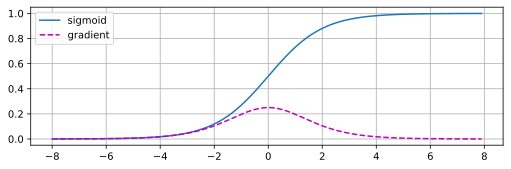

In [11]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(8.5, 2.5))

### wybuchające gradienty
* jeśli wiele macierzy wag, nawet z zerową średnią i jednostkową wariancją, wymnożymy, to wartości wynikowe wykroczą poza zakres - *wybuchną*
  * z dużym prawdopodobieństwem tak będzie przy nieostrożnej inicjalizacji
  * ZADANIE: przeprowadzić doświadczenie dla wielu macierzy

### symetria
* prosty przypadek: inicjalizujemy *wszystkie* macierze wag na macierze jednostkowe
  * wszystkie neurony pierwszej warstwy mają te same wejścia, te same warstwy, osiągają te same wartości aktywacji
  * tak dzieje się do warstwy wyjściowej
  * gradienty dla neuronów w warstwie mają te same wartości
  * sieć nie nauczy się nigdy...

## Inicjalizacja wag
* pierwszym postulatem jest, w przypadku aktywacji sigmoidalnej, aby wartości oczekiwane sum ważonych były na początku nauczania zbliżone do zera
  * ponieważ tam sigmoidalna funkcja ma największy gradient i szybko przesunie się w kierunku wartości pożądanych

[Wizualizacja inicjalizacji: zerowe, małe, duże, odpowiednie [deeplearning.ai]](https://www.deeplearning.ai/ai-notes/initialization/index.html)
### metoda inicjalizacji Xavier [Xavier Glorot, Yoshua Bengio, 2010]
  * suma ważona neuronów w warstwie $l+1$ będzie $v_i=\sum_jw_{ij}x_j$ po $j=1\dots{}n_{l}$
  * wagi wylosowane z tego samego rozkładu, niezależnie od siebie, niezależnie od rozkładu $x$, z zerową średnią i wariancją $\sigma^2$
  * wartość oczekiwana $$E[v_i]=\sum_jE[w_{ij}x_j]=\sum_jE[w_{ij}][E[x_j]=\sum_j0\cdot[E[x_j]=0$$
  * wariancja $$var[v_i]=E[v_i^2]-E[v_i]^2=\sum_jE[w_{ij}^2x_j^2]-0=\sum_jE[w_{ij}^2]E[x_j^2]=n_{in}\sigma^2\gamma^2$$
    * $\gamma^2$ to wariancja $x$ (ze średnią 0)
  * aby zapewnić, że przy mnożeniu macierzy utrzymujemy wariancję wartości, przy średniej 0, w pewnych granicach, potrzebujemy kontrolować wariancję
    * metodą będzie ustalenie, by $n_{l}\sigma^2=1$
  * podobnie dla warstwy $l+1$, przy wstecznej propagacji, potrzebujemy zapewnić by $n_{l+1}\sigma^2=1$
* zapewnienie naraz obu jednocześnie nie jest możliwe
  * inicjalizacja Xaviera postuluje aby zapewnić $$\dfrac{1}{2}(n_{l}+n_{l+1})\sigma^2=1$$
  * inicjalizacja Xaviera próbkuje z rozkładu normalnego z wariancją $\sigma^2=\dfrac{2}{n_{l}+n_{l+1}}$
  * dla rozkładu równomiernego $U(-a, +a)$ próbkujemy z $$U\left(-\sqrt{\dfrac{6}{n_{l}+n_{l+1}}}, +\sqrt{\dfrac{6}{n_{l}+n_{l+1}}}\right)$$
    * wariancja rozkładu $U(-a,+a)$ wynosi $a^2/3$
  * biasy są inicjalizowane na zero
* metoda Xavier jest przewidziana dla aktywacji typu **symetrycznego**, np.  sigmoidalnego czy liniowego
* 
[Wizualizacja inicjalizacji - efekt inicjalizacji Xavier [deeplearning.ai]](https://www.deeplearning.ai/ai-notes/initialization/index.html)

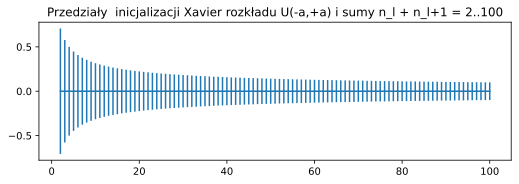

In [34]:
values = [i for i in range(2, 101)]
results = [np.sqrt(1.0 / n) for n in values]
plt.errorbar(values, [0.0 for _ in values], yerr=results)
plt.title("Przedziały  inicjalizacji Xavier rozkładu U(-a,+a) i sumy n_l + n_l+1 = 2..100")
plt.show()

#### Uzasadnienie dla Xavier
* na początku uczenia wagi są w **liniowym** zakresie aktywacji
* utrzymuje taką samą wariancję we wszystkich warstwach $Var[v^l]=Var[v^{l+1}]$
* utrzymanie wariancji gwałtownie wpływa na reakcję sieci
$$
n_l\cdot{}Var[W^{l+1}]
\begin{cases}
<1&\Longrightarrow \textrm{zanikający gradient}\\
=1&\Longrightarrow Var[v^l]=Var[v^{l+1}\\
>1&\Longrightarrow \textrm{eksplodujący gradient}
\end{cases}$$

### Adaptacja dla ReLU - inicjalizacja He
* funkcja aktywacji nie jest symetryczna
* podobne założenia:
  * wartości oczekiwane wejść i wag równe 0,
  * niezależne rozkłady wag i wejść;  z identycznych rozkładów (osobno wagi i wejścia),
  * biasy inicjalizowane na zero - nie mamy żadnej wiedzy czy neuron powinien być aktywowany, czy nie,
  * jednak aktywacja jest asymetryczna.
* dla asymetrycznego ReLU wyprowadzenia są inne,
  * wartość oczekiwana $E[v_i]=0$
  * wariancja $E[v_i]=E[v_i^2]-E[v_i]^2$
  $$\begin{align}
  E[v_i^2]&=\int_{-\infty}^\infty{}v_iP(v)dv=\int_{-\infty}^\infty{}\max(0,y)^2Pydy\\
  &=\int_0^\infty{}y^2Py=\dfrac{1}{2}\int_0^\infty{}y^2Pydy\\
  &={1}/{2}\cdot{}var[y]
  \end{align}$$
  * stąd wariacja w warstwie $l+1$ $$var[y^l]=1/2\cdot{}n_{l+1}\cdot{}W^{l+1}\cdot{}var[x]$$
  * a łącząc wszystkie warstwy od pierszej do L-tej dostajemy
    $$var[y^L]=var[y^1]\left(\prod_{l=2}^L\dfrac{n_{l}}{2}W^{l+1}var[W^l]\right)$$
  * znowu warunkiem aby wagi nie eksplodowały jest utrzymanie składnika wewnątrz produktu w ustalonej wartości, a więc aby $$\dfrac{n_{l}}{2}W^{l+1}var[W^l]=1$$
  * wagi w inicjalizacji He są próbkowane z rozkładu normalnego $\mathcal{N}(0, \sqrt{2/n})$ dla n wejść
    * to jest rozwiązanie dla ReLU w każdej warstwie - podobne rozwiązania dla podobnych aktywacji typu [PReLU(x)=max(0,x)+a∗min(0,x)](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html?highlight=prelu#torch.nn.PReLU) 
 


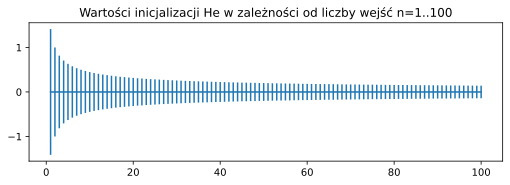

In [35]:
values = [i for i in range(1, 101)]
results = [np.sqrt(2.0 / n) for n in values]
plt.errorbar(values, [0.0 for _ in values], yerr=results)
plt.title("Wartości inicjalizacji He w zależności od liczby wejść n=1..100")
plt.show()

## Dropout — specjalna warstwa 
* dobra regularyzacja może być osiągana dzięki prostym modelom o małej liczbie parametrów - patrz tzw. brzytwa Ockhama
  * model może przybliżyć praktycznie każdą funkcję dzięki dużej liczbie parametrów, funkcjom bazowym, tzw. feature engineering, ale to często jest okupione słabą generalizacją [overfitting](./23_Overfitting.ipynb)
  * stąd modele regularyzacji typu weight decay
* modele powinny spełniać warunek **ciągłosci** - model powinien zwracać podobną wartość jeśli dane (wagi) są zaburzone w niewielkim stopniu
  * odpowiada [Bishop] tzw. regularyzacji Tikhonova
    * w podejściu Bishopa do każdego wejścia dodawany był szum $x'=x+\epsilon$ dla $\epsilon\sim\mathcal{N}(0,\sigma^2)$
    * nie zmienia wartości oczekiwanej
  * wiele znanych modeli opartych na tej idei, np. denoising autoencoder DAE, wiele innych
* proste rozwiązanie przez **dropout** [Srivastava, Hinton, Krizhevsky, Sutskever, Salakhutdinov, Droput: how to prevent neural networks from overfitting, JMLR 2014](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
  * dodawanie szumu do wewnętrznych warstw w czasie uczenia
  * skąd nazwa **dropout**? — część neuronów jest losowo usuwana

<img style="float: left;" src="ml_figures/dropout-before.png" width=250> 

### działanie
* modyfikacja, z prawdopodobieństwem $p\in[0,1)$ wartości w warstwach ukrytych i wejściowych
$$
y'=\begin{cases}
0&\textrm{z prawdopodobieństwem $p$},\\
\dfrac{y}{1-p}&\textrm{w przeciwnym wypadku }
\end{cases}
$$
  * wartość oczekiwana aktywacji bez zmian $$E[y']=0\cdot{}p+\dfrac{y}{1-p}\cdot{}(1-p)=y$$
<img style="float: right;" src="ml_figures/dropout-after.png" width=250> 
* zerowanie aktywacji jest równoważne usuwaniu neuronów jak **pruning** sieci
  * to zmniejsza liczbę użytych parametrów modelu
  * dzieje się to stochastycznie
  * w każdym kroku uczenia usuwane są inne neurony
  * w żadnym stopniu nie wpływa na algorytm wstecznej propagacji

### Czemu dropout działa? Jaka jest (może być) intuicja?
* zwykle $p\sim{}U(0,1)$, chociaż częściej bliżej 1* w trakcie testów (czy użycia) czy użycia neurony **nie są zerowane**
  * możliwe jest usuwanie dla testowania ciągłości modelu — niezależności od zaburzeń
  * sieć złożona z $n$ neuronów może być widziana jako zbiór $2^n$ różnych sieci z usuniętymi neuronami
  * na trenowanie z użyciem dropout można spojrzeć jako trenowanie tego zbioru współdzielącego dużą liczbę parametrów
  * w trakcie testowania (użycia) nie możemy uśredniać $2^n$ modeli, ale
    * używamy jednej sieci bez dropout
    * w trakcie uczenia niektóre neurony były często usuwane, stąd wychodzące z nich wagi nie były modyfikowane i traktowane jak zerowe
    * jej wagi są przeskalowanymi wartościami oryginalnej sieci
      * jeśli, w trakcie uczenia, neuron **był utrzymywany z prawdopodobieństwem $p$** to wszystkie wychodzące wagi **mnożymy przez p**
      * dzięki temu przekazywana wartość oczekiwana aktywacji neuronu pozostaje bez zmian
    * w ten sposób wykorzystywaną sieć można traktować jako **złożenie** (ang. ensemble) $2^n$ modeli współdzielących wagi
* dropout jest modelem do użycia dla każdego typu sieci
  * warstwowych, konwolucyjnych, rekurencyjnych, maszyn Boltzmanna, ResNet, etc, etc
  * możliwa do użycia w każdym miejscu modelu
* dropout (sporo) wydłuża czas uczenia, jednak zyski są większe

## Batch normalization [[Ioffe, Shegedy, 2015](https://proceedings.mlr.press/v37/ioffe15.html)]
* dla prędkości i stabilności uczenia dobrze jest, by aktywacje poprzedniej warstwy (danych) miały zerową średnią $\mu=0$ i jednostkową wariancję $\Sigma=1$
  * zwykle dane są przetwarzane by to uzyskać dla każdej obserwacji
  * niektóre twierdzenia mówiące o oczekiwanej generalizacji, np. tzw. wymiar Vapnika-Chervonenkisa, są zależne od spełnienia tego warunku
  * najprostsze wytłumaczenie jest takie, że sumy ważone pierwszej warstwy ukrytej będą w przedziale liniowości funkcji aktywacji (dla funkcji symetrycznych) pozwalając na szybkie uczenie
 
* czy nie można uzyskać tego samego dla kolejnych warstw ukrytych?
  * uczenie będzie bardziej stabilne, jeśli wszystkie neurony w warstwie będą osiągać podobne przedziały wartości
  * także jeśli to będzie się działo przez cały okres uczenia sieci, dla różnych przykładów
    * normalizacja potrzebuje być adaptatywna

* proces batch normalization
  * od danych, w każdym kroku, odejmujemy średnią i dzielimy przez odchylenie standardowe opierając się na **statystykach aktualnego batcha**
  * dane są skalowane i przesuwane by odzyskać stopnie swobody
  $$BN(x)=\gamma\odot\dfrac{x-\hat\mu_\mathcal{B}}{\hat\sigma_\mathcal{B}}+\beta$$
gdzie
    * $\hat\mu_\mathcal{B}$ - średnia batcha
    * $\hat\sigma_\mathcal{B}$ - standardowe odchylenie batcha
    * parametry skalowania $\gamma$ i offsetu $\beta$
      * dzielenia przez $\hat\sigma_\mathcal{B}$ powoduje, że uzyskamy jednostkową wariancję
      * ten wybór jest arbitralny
      * potrzebne jest odzyskanie oryginalnych stopni swobody przez przeskalowanie i przesunięcie
      * parametry $\gamma$ i $\beta$ są znajdywane w trakcie uczenia
      * $\odot$ oznacza mnożenie skalar po skalarze (ang. elementwise)
    * dzieje się to stochastycznie - obliczanie średnich i wariancji jest oparte na próbkach
  $$
  \hat\mu_\mathcal{B}=\dfrac{1}{|\mathcal{B}|}\sum_{x\in\mathcal{B}}x\;\;\;\;\;\;\;\;
  \hat\sigma_\mathcal{B}=\dfrac{1}{|\mathcal{B}|}\sum_{x\in\mathcal{B}}(x-\hat\mu_\mathcal{B})^2+\epsilon
  $$
  * batch normalization działa zwykle najlepiej dla średniej wielkości batchy
    * wydaje się, że taki rozmiar wprowadza dobrej wielkości szum
  * w trakcie *uczenia* statystyki obliczane są na podstawie batchy
  * w trakcie użycia (predykcji) natomiast na podstawie całego zbioru (tego akurat dostępnego)

### Warstwy BatchNorm
* w którym miejscu powinny być umieszczone warstwy BatchNorm?
  * po obliczeniu sum ważonych a przed aktywacją?
  * albo po aktywacji?
 
* [Ioffe \& Szegedy, 2015] proponują, dla sieci warstwowych typu MLP, umieścić **między warstwą liniową a nieliniowymi aktywacjami**
* wiele późniejszych doświadczeń według schematu $y=\phi(BN(Wx+b))$
  * w sieci można znaleźć **mnóstwo** logicznych argumentów za jednym i drugim
* podobnie w sieciach konwolucyjnych, ale **osobno** dla każdego kanału

### Warstwy Layer Normalization
* alternatywa działająca na **pojedynczych przykładach**
$$\begin{align}
LN(x)&=\dfrac{x-\hat\mu_\mathcal{B}}{\hat\sigma_\mathcal{B}}\\
\hat\mu_\mathcal{B}&=\dfrac{1}{n}\sum_{i=1}^nx_i\;\;\;\;\;\;\;\;
\hat\sigma_\mathcal{B}=\dfrac{1}{n}\sum_{i=1}^n(x_i-\hat\mu_\mathcal{B})^2+\epsilon
\end{align}$$
gdzie $n$ jest wymiarem przykładów
  * layer normalization zwykle zapobiega rozbieżności uczenia
  * jest niezależne od wymiaru batchy
#### Czemu BatchNorm działa?
* nie ma dobrej teorii na ten temat
  * wiele osób w ogóle zaprzecza działaniu, ale ten efekt jest często zwiazany z nieprawidłową implementacją bądź użyciem
* [Ioffe \& Szegedy] zaproponowali pojęcie *internal covariate shift*
  * że rozkład danych zmienia się w trakcie uczenia
  * to jest jednak tzw. misnomer, trzeba powiedzieć, że to jest **concept drift**, chociaż nie ma pewności co do tego wytłumaczenia
  * są tysiące wytłumaczeń...
* uwagi
  * w trakcie nauko, BN ciągle modyfikuje pośrednie aktywacje, poprzez średnie i wariancje dla batchy, co powoduje, że są one bardziej stabilne
  * dla sieci konwolucyjnych często lepiej działa Layer Normalization
  * tryby działania BatchNorm w trakcie uczenia i predykcji są różne
    * pamietać aby w PyTorch **odpowiednio przełączyć**
  * BN jest warstwą regularyzacyjną i przyspieszająca zbieżność
  * dla prostych modeli bardziej odpornych na wewnętrzny szum warto sprawdzić jak model działa bez BN